# MODELO 4 - CGAN para generar una imagen del CIFAR-100 a pedido del usuario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


- Importo las librerias neceasarias

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar100
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [4]:
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]

print(img_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

32
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

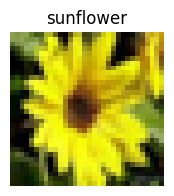

In [5]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

# Construcción del generador

In [6]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 256 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = Reshape((img_size_in, img_size_in, 256), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 16x16x256
    gen = BatchNormalization(name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 32x32x128
    gen = BatchNormalization(name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', name='Conv2DTranspose_3')(gen)  # 32x32x64
    gen = BatchNormalization(name='Generator_BatchNormalization_3')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2D(3, (8, 8), activation='tanh', padding='same', name='Output_Conv2D_1')(gen)  # 32x32x3 
    #---------------------------------------------------------------------------------#

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='/content/drive/MyDrive/Lembo/generator_structure_m4_cifar100.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [7]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 16x16x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 8x8x64
    fe = BatchNormalization(name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2D_3')(fe) # 4x4x128
    fe = BatchNormalization(name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same', name='Conv2D_4')(fe) # 2x2x256
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    out_layer = Dense(1, activation='sigmoid', name='Output_Dense')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='/content/drive/MyDrive/Lembo/discriminator_structure_m4_cifar100.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [8]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("/content/drive/MyDrive/Lembo/evolution_m4_cifar100", exist_ok=True)
  plt.savefig(f"/content/drive/MyDrive/Lembo/evolution_m4_cifar100/images_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [9]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [10]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [11]:
epoch_count = 50 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [ ]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

- Construyo el discriminador

In [ ]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [ ]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = g_model([noise, real_labels], training = True) #  Genero imagenes falsas
            pred_real = d_model([real_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes reales
            pred_fake = d_model([generated_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes falsas

            g_loss = generator_loss(pred_fake) # Calculo la loss del generador
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        grads_g = gen_tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        grads_d = disc_tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes

        g_optimizer.apply_gradients(zip(grads_g, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador
        d_optimizer.apply_gradients(zip(grads_d, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [ ]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch

        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([random_latent_vectors, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas


        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        fake_images = g_model([random_latent_vectors, real_labels]) # Genero imagenes falsas
        predictions = d_model([fake_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        g_loss = generator_loss(predictions) # Calculo la loss del generador

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [ ]:
def train(train_dataset, test_dataset, epoch_count, batch_size):
    
    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0
 
    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento
            
            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train 
            g_loss_list_batch_train_aux[itern] = g_loss_train  
            d_loss_list_itern_train[itern_train_counter] = d_loss_train  
            g_loss_list_itern_train[itern_train_counter] = g_loss_train  
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train
            
            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1 

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo
            
            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test 
            d_loss_list_itern_test[itern_test_counter] = d_loss_test 
            g_loss_list_itern_test[itern_test_counter] = g_loss_test 
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test

            itern=itern+1 
        
        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m4_cifar100.keras")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.h5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m4_cifar100.h5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.tf")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m4_cifar100.tf")

# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_itern_train']
d_loss_itern_test = data['d_loss_itern_test']
g_loss_itern_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz")

epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

In [ ]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m4_cifar100.npz")
epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()

# Generación de una imagen del cifar 100 pedida por el usuario

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image

noise_dim = 100 # Dimension del ruido

tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
def get_index(word, tags_list):
    try:
        return tags_list.index(word)
    except ValueError:
        return -1  # Devuelve -1 si la palabra no se encuentra en la lista
    
# Cargar el modelo generador
g_model = load_model('/content/drive/MyDrive/Lembo/gmodel_m4_cifar100.keras')

imagen_a_generar = 'apple'
index = get_index(imagen_a_generar, tags)

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*index

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{tags[index]}")
plt.show()